In [ ]:
!pip install torchinfo
import os
os.chdir('/content/drive/MyDrive/Spin/Potts')

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import torch.nn.utils.prune as prune

import torch
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision import transforms
from torchinfo import summary
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score


from loader.loader import pottsloader

In [ ]:
batch_size = 64

trainset_qPotts = pottsloader('data/potts/2_potts/L64')

train, test = train_test_split(trainset_qPotts, test_size=0.3)

train_loader = DataLoader(
        train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(
        test, batch_size=batch_size, shuffle=True)

print('샘플 개수 :', len(trainset_qPotts))

샘플 개수 : 188000


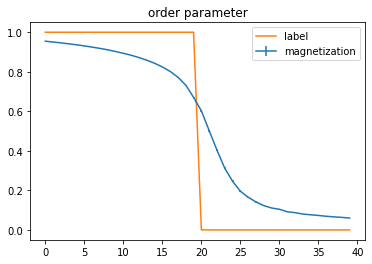

In [ ]:
orderparam = np.zeros(40)
errorbar = np.zeros(40)
phases = np.zeros(40)
T_arr = np.linspace(0, len(trainset_qPotts) , 41, dtype = int)
magnet = []
phase = []
j = 0
for idx, (X, Y) in enumerate(trainset_qPotts,start = 1):
    if idx in T_arr:
        orderparam[j] = np.average(np.array(magnet))
        errorbar[j] = 2*np.std(np.array(magnet))/ np.sqrt(4700)
        phases[j] = np.average(np.array(phase))
        j += 1
        magnet = []
        phase = []
    else:
        magnet.append(torch.abs(2*(torch.mean(X)-0.5)))
        phase.append(Y)
plt.title('order parameter')
plt.errorbar(range(len(orderparam)),orderparam,errorbar , label = 'magnetization')
plt.plot(range(len(orderparam)),1- phases, label = 'label')
plt.legend()
plt.show()

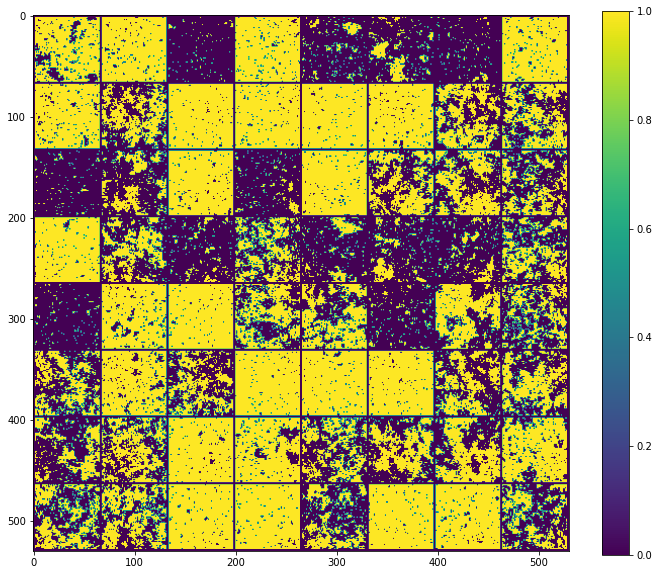

In [ ]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))[:,:,0])
    plt.colorbar()
    plt.show()

inputs, targets = next(iter(train_loader))
plt.figure(figsize=(12,10))
imshow(make_grid(inputs, nrow=8))

In [ ]:
class lightCNN(torch.nn.Module):

    def __init__(self):
        super(lightCNN, self).__init__()

        self.keep_prob = 0.5
        
        # L0 ImgIn shape=(batch, 64, 64, 1)
        #    Conv     -> (batch, 64, 64, 32)
        #    Pool     -> (batch, 32, 32, 32)
        self.layer0 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),# 3x3x3x32
            torch.nn.BatchNorm2d(1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(1, 32, kernel_size=1, stride=1, padding=0),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
        # L1 ImgIn shape=(batch, 32, 32, 32)
        #    Conv     -> (batch, 32, 32, 64)
        #    Pool     -> (batch, 16, 16, 64)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=1, stride=1, padding=0),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
        # L2 ImgIn shape=(?, 16, 16, 64)
        #    Conv      ->(?, 16, 16, 128)
        #    Pool      ->(?, 8, 8, 128)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 128, kernel_size=1, stride=1, padding=0),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
        # L3 ImgIn shape=(?, 8, 8 128)
        #    Conv      ->(?, 8, 8, 256)
        #    Pool      ->(?, 4, 4, 256)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, 256, kernel_size=1, stride=1, padding=0),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        # FC 5x5x256 inputs -> 2000 outputs -> 2
        self.fc1 = torch.nn.Sequential(
            torch.nn.Linear(4 * 4 * 256, 2000, bias=True),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1 - self.keep_prob)) # L5 Final FC 2000 inputs -> 1 outputs
        
        self.fc2 = torch.nn.Linear(2000, 2, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
                                      
    def forward(self, x):
        out = self.layer0(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [ ]:
model = lightCNN().to('cuda')
learning_rate = 0.001
training_epochs = 6

criterion = torch.nn.CrossEntropyLoss()    # 비용 함수에 소프트맥스 함수 포함되어져 있음.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

module = model.fc1[0]
prune.random_unstructured(module, name="weight", amount=0.8)
print(summary(model))

Layer (type:depth-idx)                   Param #
lightCNN                                 --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       10
│    └─BatchNorm2d: 2-2                  2
│    └─ReLU: 2-3                         --
│    └─Conv2d: 2-4                       64
│    └─BatchNorm2d: 2-5                  64
│    └─ReLU: 2-6                         --
│    └─MaxPool2d: 2-7                    --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-8                       9,248
│    └─BatchNorm2d: 2-9                  64
│    └─ReLU: 2-10                        --
│    └─Conv2d: 2-11                      2,112
│    └─BatchNorm2d: 2-12                 128
│    └─ReLU: 2-13                        --
│    └─MaxPool2d: 2-14                   --
├─Sequential: 1-3                        --
│    └─Conv2d: 2-15                      36,928
│    └─BatchNorm2d: 2-16                 128
│    └─ReLU: 2-17                        --
│    └─Conv2d: 2

In [ ]:
for epoch in tqdm(range(training_epochs)):
    avg_cost = 0

    for idx, (X, Y) in enumerate(train_loader):
        X = X.to('cuda')
        Y = Y.to('cuda')

        optimizer.zero_grad()
        predict = model(X)
        cost = criterion(predict, Y)
        cost.backward()
        optimizer.step()
        avg_cost += cost

    acc = []
    f1 = []
    valid_losses = []  
    for idx, (X, Y) in enumerate(test_loader):
        X = X.to('cuda')
        Y = Y.to('cuda')
        predict = model(X)
        valid_loss = criterion(predict, Y)
        valid_losses.append(valid_loss.detach().cpu())
        predict = predict.argmax(dim = 1)
        acc.append((Y == predict).sum() / 64)
        f1.append(f1_score(Y.detach().cpu(), predict.detach().cpu(),average = 'macro'))
    print(f'Cross Entropy : {sum(valid_losses)/len(valid_losses)}, Accuracy : {sum(acc)/len(acc)} , f1_score : {sum(f1)/len(f1)} ')

    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))
    prune.ln_structured(module, name="weight", amount=0.1, n=2, dim=0)

 17%|█▋        | 1/6 [02:02<10:14, 122.83s/it]

Cross Entropy : 0.0909653827548027, Accuracy : 0.9613626599311829 , f1_score : 0.9617381831355292 
[Epoch:    1] cost = 175.183304


 33%|███▎      | 2/6 [04:05<08:10, 122.66s/it]

Cross Entropy : 0.06905651837587357, Accuracy : 0.9707164168357849 , f1_score : 0.9711913401240702 
[Epoch:    2] cost = 146.63327


 50%|█████     | 3/6 [06:07<06:07, 122.61s/it]

Cross Entropy : 0.05862195044755936, Accuracy : 0.9742949604988098 , f1_score : 0.9747653713786478 
[Epoch:    3] cost = 136.528931


 67%|██████▋   | 4/6 [08:10<04:05, 122.55s/it]

Cross Entropy : 0.0618954673409462, Accuracy : 0.9729485511779785 , f1_score : 0.9733475633704303 
[Epoch:    4] cost = 127.929428


 83%|████████▎ | 5/6 [10:13<02:02, 122.81s/it]

Cross Entropy : 0.058096934109926224, Accuracy : 0.975039005279541 , f1_score : 0.9754797634301733 
[Epoch:    5] cost = 125.20417


100%|██████████| 6/6 [12:16<00:00, 122.83s/it]

Cross Entropy : 0.05771762877702713, Accuracy : 0.9747024178504944 , f1_score : 0.9751739034103936 
[Epoch:    6] cost = 120.36113


In [ ]:
print(summary(model))

Layer (type:depth-idx)                   Param #
lightCNN                                 --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       10
│    └─BatchNorm2d: 2-2                  2
│    └─ReLU: 2-3                         --
│    └─Conv2d: 2-4                       64
│    └─BatchNorm2d: 2-5                  64
│    └─ReLU: 2-6                         --
│    └─MaxPool2d: 2-7                    --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-8                       9,248
│    └─BatchNorm2d: 2-9                  64
│    └─ReLU: 2-10                        --
│    └─Conv2d: 2-11                      2,112
│    └─BatchNorm2d: 2-12                 128
│    └─ReLU: 2-13                        --
│    └─MaxPool2d: 2-14                   --
├─Sequential: 1-3                        --
│    └─Conv2d: 2-15                      36,928
│    └─BatchNorm2d: 2-16                 128
│    └─ReLU: 2-17                        --
│    └─Conv2d: 2

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


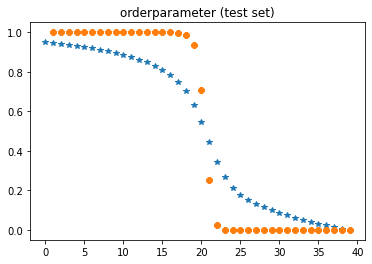

In [ ]:
magnet = []
label = []
i = 0
for idx, (X, Y) in enumerate(test_loader):
  X = X.to('cuda')
  predict = model(X)
  predict = predict.argmax(dim = 1)
  label.extend(predict)
  X = X.to('cpu')
  for X_one, Y_one in zip(X,Y):
    magnet.append( (torch.abs(2*(torch.mean(X_one)-0.5)), i ))
    i += 1

magnet.sort(key=lambda x : (x[0], x[1]))

label_sorted = []
mag = []
bin_label = []
bin_mag = []

T_arr = np.linspace(0, len(magnet) , 41, dtype = int)
for i,(m,idx) in enumerate(magnet):
  if i in T_arr:
    bin_mag.append(np.average(np.array(mag)))
    bin_label.append(torch.mean(torch.tensor(label_sorted, dtype = torch.float32)))
    label_sorted = []
    mag = []
  else:
    label_sorted.append(label[idx])
    mag.append(m)
plt.title('orderparameter (test set)')
plt.plot(range(40) ,bin_mag[::-1],'*', label = 'true')
plt.plot(range(40), bin_label,'8',label = 'predict')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


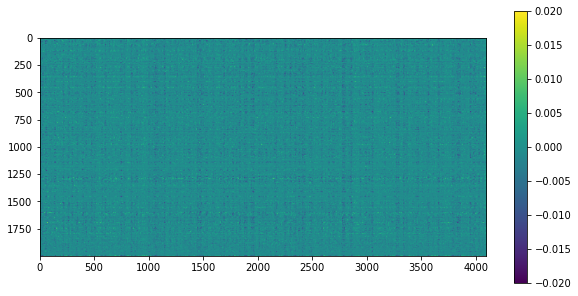

In [ ]:
weight = torch.tensor(model.fc1[0].weight).to('cpu')
weight = weight.numpy()
plt.figure(figsize = (10,5))
plt.imshow(weight)
plt.colorbar()
plt.clim(-0.02, 0.02)
plt.show()